In [2]:
import pandas as pd

csv_file = "Evaluated tweets - Copy.csv"

df = pd.read_csv(
    csv_file,
    sep=';',            
    encoding='cp1252',   
    engine='python'      
)

df.head()

,id,text,Evaluation
0,1241411864422223877,"""Clearly this must mean easyJet has no need of...",Negative
1,1135187083172155392,"""@EtihadAirways booked business class, no cont...",Negative
2,1142061346210635777,"""@candktravel @AmericanAir @Delta @united @Jet...",Negative
3,1178399552975654912,"""And now a @KLM CSR has confirmed they actuall...",Negative
4,1172231533492625408,"""@British_Airways IÕm supposedly on BA0281, an...",Negative


In [3]:
df['id'] = df['id'].astype(str)

In [5]:
import requests
from secret import password, url

ids = df['id'].tolist()

payload = {
    "statements": [
        {
            "statement": """
            UNWIND $ids AS id
            MATCH (t:Tweet {id: id})
            RETURN id AS tweet_id, t.sentiment_label AS sentiment_label
            """,
            "parameters": {"ids": ids}
        }
    ]
}

headers = {"Content-Type": "application/json"}
resp = requests.post(
    url,
    auth=("neo4j", password),
    json=payload,
    headers=headers
)
resp.raise_for_status()
data = resp.json()

rows = data['results'][0]['data']
result = [(r['row'][0], r['row'][1]) for r in rows]
sentiment_df = pd.DataFrame(result, columns=['tweet_id', 'sentiment_label'])

In [6]:
merged_df = df.set_index('id').join(sentiment_df.set_index('tweet_id'),how='left')
merged_df.rename(columns={'Evaluation': 'human_labeled','sentiment_label':'model_labeled' }, inplace=True)
merged_df['human_labeled']=merged_df['human_labeled'].str.lower()

In [7]:
df=merged_df
from sklearn.metrics import confusion_matrix

labels = ['positive', 'neutral', 'negative']  

cm = confusion_matrix(
    y_true=df['human_labeled'],
    y_pred=df['model_labeled'],
    labels=labels
)

cm_df = pd.DataFrame(
    cm,
    index=pd.Index(labels, name='Human labeled'),
    columns=pd.Index(labels, name='Model labeled')
)

print(cm_df)

Model labeled  positive  neutral  negative
Human labeled                             
positive             14        1         1
neutral               3       27         5
negative              4        9        36


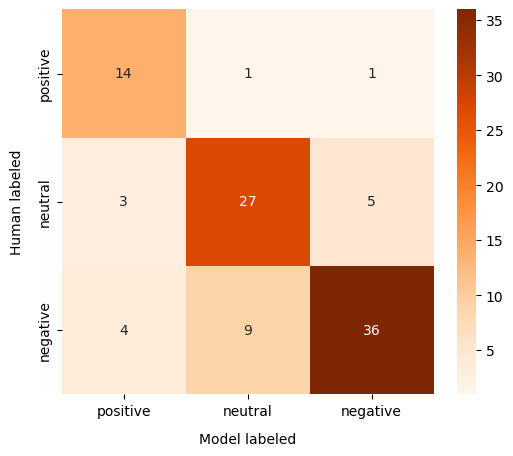

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  

plt.figure(figsize=(6,5))
ax=sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')
ax.set_ylabel('Human labeled', labelpad=10)
ax.set_xlabel('Model labeled',  labelpad=10)
plt.show() #check